## Load the necessary libariary and data

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import scipy.stats as stats
import seaborn as sns
import pickle
import time
import random
import matplotlib.pyplot as plt


try: 
    import cudf as pd
except:
    import pandas as pd

# if cuda is available, use cudf instead of pandas
from IPython.display import Image

try:
    import cuml
    from cuml.linear_model import LinearRegression,SGDClassifier
    from cuml.decomposition import PCA
    from cuml.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
    from cuml.metrics.regression import r2_score
    from cuml.model_selection import train_test_split
    from cuml.impute import SimpleImputer
    from cuml.feature_selection import VarianceThreshold, SelectKBest

except:
    from sklearn.feature_selection import VarianceThreshold, SelectKBest
    from sklearn.impute import SimpleImputer
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
    from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.neural_network import MLPRegressor
    from sklearn.metrics import r2_score, f1_score
    from sklearn.metrics import roc_curve, auc


warnings.filterwarnings('ignore', category=FutureWarning)

train = pd.read_csv('./data/train.csv')
train_labels = train[['regression target', 'classification target']]
train = train.drop(['regression target', 'classification target'], axis=1)
test = pd.read_csv('./data/test.csv')

#### Tuning Variables:

In [32]:
# fixed variables
random_seed = 4211

# Feature Engineering
n_index = 0
c_index = 0
f_index = 0
fe_index = 0
n_pca = 15

# Model selection and validation
running_index = 0 # -1 for tuning and testing, please RESET to -1 after running

## Feedforward Neural Network
repeats_index = 3 

## Logistic Regression
lr_para = {
    'learning_rate':'constant', 
    'eta0':0.01, 
    'max_iter':1000, 
    'tol':1e-3
    }

In [33]:
### Different models
if running_index == -1:
    n_index = 0
    c_index = 2
    f_index = 0
    fe_index = 1
    n_pca = 5

if running_index in [0,1,2,3,4,5,6,7,8,9]:
    n_index = 1
    c_index = 2
    fe_index = 1

## Part 2:  Data Preprocessing Techniques

### [Q7] Handling Missing Values: 

In [34]:
imputer = SimpleImputer(strategy='mean')

numeric_data = train.select_dtypes(include=[np.number])
numeric_data_imputed = imputer.fit_transform(numeric_data)

train[numeric_data.columns] = numeric_data_imputed

### [Q8] Normalization and Standardization:

In [35]:
scaler_SS = StandardScaler()
scaler_MM = MinMaxScaler()
scaler_RS = RobustScaler()

train_SS = train.copy()
train_MM = train.copy()
train_RS = train.copy()

train_SS[numeric_data.columns] = scaler_SS.fit_transform(numeric_data_imputed)
train_MM[numeric_data.columns] = scaler_MM.fit_transform(numeric_data_imputed)
train_RS[numeric_data.columns] = scaler_RS.fit_transform(numeric_data_imputed)

first_numeric_column_index = 0
for i in range(len(train.columns)):
    column_name = train.columns[i]
    if train[column_name].dtype != 'object':
        first_numeric_column_index = i
        break

print('Original: ')
print(train.iloc[:, first_numeric_column_index].head(10))
print('Standard Scaler: ')
print(train_SS.iloc[:, first_numeric_column_index].head(10))
print('MinMax Scaler: ')
print(train_MM.iloc[:, first_numeric_column_index].head(10))
print('Robust Scaler: ')
print(train_RS.iloc[:, first_numeric_column_index].head(10))

Original: 
0    65.00
1    65.00
2    59.50
3    66.55
4    71.00
5    70.00
6    57.50
7    65.50
8    70.00
9    80.00
Name: C6, dtype: float64
Standard Scaler: 
0   -0.200135
1   -0.200135
2   -1.031074
3    0.034039
4    0.706344
5    0.555264
6   -1.333234
7   -0.124595
8    0.555264
9    2.066063
Name: C6, dtype: float64
MinMax Scaler: 
0    0.368421
1    0.368421
2    0.252632
3    0.401053
4    0.494737
5    0.473684
6    0.210526
7    0.378947
8    0.473684
9    0.684211
Name: C6, dtype: float64
Robust Scaler: 
0   -0.206667
1   -0.206667
2   -0.940000
3    0.000000
4    0.593333
5    0.460000
6   -1.206667
7   -0.140000
8    0.460000
9    1.793333
Name: C6, dtype: float64


### [Q9] Encoding Categorical Variables:

In [36]:
# using OneHotEncoder and OrdinalEncoder to encode the categorical data

encoder_OHE = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder_OE = OrdinalEncoder()

categorical_data = train[train.columns.difference(numeric_data.columns)]

categorical_data_encoded_OHE = pd.DataFrame()

for column in categorical_data.columns:
    encoded_column = encoder_OHE.fit_transform(categorical_data[[column]])
    column_names = [f"{column}_{category}" for category in encoder_OHE.categories_[0]]
    encoded_column = pd.DataFrame(encoded_column, columns=column_names)
    categorical_data_encoded_OHE = pd.concat([categorical_data_encoded_OHE, encoded_column], axis=1)
    
categorical_data_encoded_OE = pd.DataFrame(encoder_OE.fit_transform(categorical_data), columns=categorical_data.columns)

print('Original: ')
print(categorical_data.iloc[:10, 0])

print('OneHotEncoder: ')
print(categorical_data_encoded_OHE.iloc[:10, 0:7])

print('OrdinalEncoder: ')
print(categorical_data_encoded_OE.iloc[:10, 0])

Original: 
0    divorced
1      single
2      single
3     married
4      single
5      single
6      single
7      single
8      single
9      single
Name: C0, dtype: object
OneHotEncoder: 
   C0_divorced  C0_facto union  C0_legally separated  C0_married  C0_single  \
0          1.0             0.0                   0.0         0.0        0.0   
1          0.0             0.0                   0.0         0.0        1.0   
2          0.0             0.0                   0.0         0.0        1.0   
3          0.0             0.0                   0.0         1.0        0.0   
4          0.0             0.0                   0.0         0.0        1.0   
5          0.0             0.0                   0.0         0.0        1.0   
6          0.0             0.0                   0.0         0.0        1.0   
7          0.0             0.0                   0.0         0.0        1.0   
8          0.0             0.0                   0.0         0.0        1.0   
9          0.0     

### [Q10] Feature Selection:

In [37]:
train_final = pd.DataFrame()

if n_index == 0:
    train_n = train.select_dtypes(include=[np.number])
elif n_index == 1:
    train_n = train_SS.select_dtypes(include=[np.number])
elif n_index == 2:
    train_n = train_MM.select_dtypes(include=[np.number])
else:
    train_n = train_RS.select_dtypes(include=[np.number])

if c_index == 0:
    train_c = categorical_data
elif c_index == 1:
    train_c = categorical_data_encoded_OHE
else:
    train_c = categorical_data_encoded_OE

train_final = pd.concat([train_n, train_c], axis=1)

train_c_sp = categorical_data_encoded_OE

# print(train_final.head(10))

# using VarianceThreshold or SelectKBest to select the features
selector_VT = VarianceThreshold(threshold=0.1)
selector_SKB = SelectKBest(k=15)

if f_index == 0:
    train_f = train_final
elif f_index == 1:
    train_f = selector_VT.fit_transform(train_final)
elif f_index == 2:
    train_f = imputer.fit_transform(train_final)
    train_f = selector_SKB.fit_transform(train_f, train_labels['regression target']) 
else:
    train_f = imputer.fit_transform(train_final)
    train_f = selector_SKB.fit_transform(train_f, train_labels['classification target'])



### [Q11] Feature Engineering: 

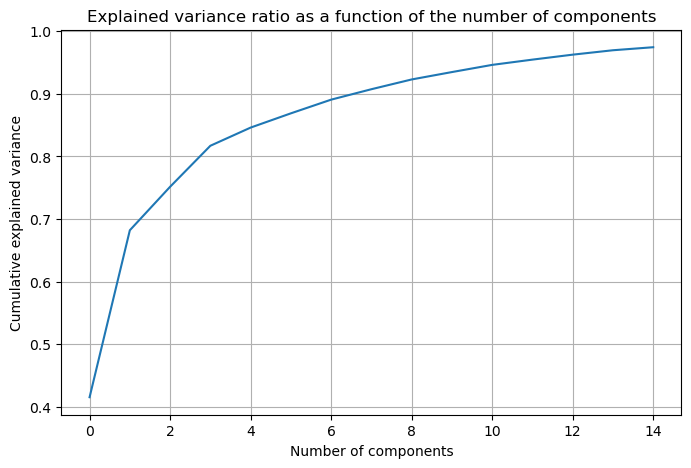

In [38]:
# using PCA, UMAP to reduce the dimensionality of the data
pca = PCA(n_components=n_pca)


if fe_index == 0:
    train_fe = train_f
elif fe_index == 1:
    train_fe = imputer.fit_transform(train_f)
    train_fe = pca.fit_transform(train_fe)
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Explained variance ratio as a function of the number of components')
    plt.grid(True)
    if not os.path.exists('./pic'):
        os.makedirs('./pic')
    plt.savefig('./pic/PCA.png')
    plt.show()
else:
    train_fe = umap.fit_transform(train_f)

## Part 3: Regression

In [39]:
np.random.seed(4211)
X_train, X_test, y_train, y_test = train_test_split(train_fe, train_labels['regression target'], test_size=0.2, random_state=4211)

### Linear Regerssion

##### Training Function for All Linear Model:

In [40]:
def train_model(X_train, y_train, X_test, y_test, n, regressor=LinearRegression()):
    index_using = [0,1,9,5,3,4]
    if n <= 5 and n >= 0:
        index = index_using[n]
        x = X_train[:,index].reshape(-1, 1)
        x_v = X_test[:,index].reshape(-1, 1)
    elif n == 6:
        index = index_using
        x = X_train[:,index]
        x_v = X_test[:,index]
    else:
        print("Invalid index")
        return None
    
    y = y_train.values 

    
    lm = regressor.fit(x, y)

    print("Coefficient:", lm.coef_)
    print("Intercept:", lm.intercept_)
    print("R^2 score:", lm.score(x, y))

    # print the validation r2 score
    y_pred = lm.predict(x_v)
    y_v = y_test.values
    print("Validation R^2 score:", r2_score(y_v, y_pred))

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
        
    with open(f'./result/regression/model{n+1}.txt', 'w') as f:
        f.write("Coefficient: " + str(lm.coef_) + '\n')
        f.write("Intercept: " + str(lm.intercept_) + '\n')
        f.write("R^2 score: " + str(lm.score(x, y)) + '\n')
        f.write("Validation R^2 score: " + str(r2_score(y_v, y_pred)) + '\n')

    with open(f'./result/regression/model{n+1}.pkl', 'wb') as f:
        pickle.dump(lm, f)

    return lm

def mse_pred(i):
    if i == 0:
        with open('./result/regression/model1.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,0].reshape(-1, 1))
    elif i == 1:
        with open('./result/regression/model2.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,1].reshape(-1, 1))
    elif i == 2:
        with open('./result/regression/model3.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,9].reshape(-1, 1))
    elif i == 3:
        with open('./result/regression/model4.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,5].reshape(-1, 1))
    elif i == 4:
        with open('./result/regression/model5.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,3].reshape(-1, 1))
    elif i == 5:
        with open('./result/regression/model6.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,4].reshape(-1, 1))
    elif i == 6:
        with open('./result/regression/model7.pkl', 'rb') as f:
            lm = pickle.load(f)
            y_pred = lm.predict(X_test[:,[0,1,3,4,5,9]])
    if i <= 6 and i >= 0:
        mse = np.mean((y_pred - y_test.values) ** 2)
        print("MSE for model", i+1, ":", mse)
        with open('./result/regression/mse.txt', 'a') as f:
            f.write("MSE for model " + str(i+1) + ": " + str(mse) + "\n")
    


#### Step 1:

##### First model:

In [41]:
# use the PCA10 of SS+OE data to regress the regression target linearly
if running_index == 0:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model1.txt', 'r') as f:
        print(f.read())

Coefficient: [0.00052226]
Intercept: 0.6338738086954843
R^2 score: 0.0018695316290635589
Validation R^2 score: 0.00494776279640774


##### Second model:

In [42]:
# use the PCA2 of SS+OE data to regress the regression target linearly
if running_index == 1:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model2.txt', 'r') as f:
        print(f.read())
        

Coefficient: [0.00040033]
Intercept: 0.6339274687727884
R^2 score: 0.0007037263251143955
Validation R^2 score: 0.005404304670441729


##### Third model:

In [43]:
# use the PCA10 of SS+OE data to regress the regression target linearly
if running_index == 2:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model3.txt', 'r') as f:
        print(f.read())

Coefficient: [0.03836043]
Intercept: 0.6341330491162769
R^2 score: 0.2805220334276459
Validation R^2 score: 0.32358168954322797


##### Forth model:

In [44]:
# use the PCA6 of SS+OE data to regress the regression target linearly
if running_index == 3:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model4.txt', 'r') as f:
        print(f.read())

Coefficient: [0.00285896]
Intercept: 0.633911316577684
R^2 score: 0.0031871125899599617
Validation R^2 score: 0.006365959135546939


##### Fifth model:

In [45]:
# use the PCA4 of SS+OE data to regress the regression target linearly
if running_index == 4:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model5.txt', 'r') as f:
        print(f.read())

Coefficient: [-0.00291074]
Intercept: 0.6339912370415771
R^2 score: 0.00938766462088203
Validation R^2 score: 0.005735289304080737


##### Sixth model:

In [46]:
# use the PCA5 of SS+OE data to regress the regression target linearly
if running_index == 5:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model6.txt', 'r') as f:
        print(f.read())

Coefficient: [-0.00324559]
Intercept: 0.6339735814916271
R^2 score: 0.004886260271825815
Validation R^2 score: 0.0072159044603422595


#### Step 2:

In [47]:
# use all used data to regress the regression target linearly
if running_index == 6:
    train_model(X_train, y_train, X_test, y_test, running_index)
    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model7.txt', 'r') as f:
        print(f.read())

Coefficient: [ 0.00046876  0.00054505  0.03858791  0.003116   -0.00312154 -0.00358015]
Intercept: 0.6340903973461227
R^2 score: 0.30375283065767555
Validation R^2 score: 0.342559269170723


#### MSE for all model:

In [48]:
# compute all MSE for all models and save it 
for i in range(7):
    mse_pred(i)

MSE for model 1 : 0.004840345917165619
MSE for model 2 : 0.004838125108535304
MSE for model 3 : 0.003290378620238816
MSE for model 4 : 0.004833447223204402
MSE for model 5 : 0.004836515062288304
MSE for model 6 : 0.004829312737366504
MSE for model 7 : 0.012916754159267995


#### Repeating Q12, Q13 using a categorical feature:

In [49]:
# use a categorical feature to regress the regression target linearly
if running_index == 7:    
    using_index = 1

    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(imputer.fit_transform(train_c_sp), train_labels['regression target'], test_size=0.2, random_state=4211)

    regressor=LinearRegression()
    
    x = X_train_c[:,using_index]
    x = x.reshape(-1, 1)
    y = y_train_c.values

    lm_8 = regressor.fit(x, y)

    print("Coefficient:", regressor.coef_)
    print("Intercept:", regressor.intercept_)
    print("R^2 score:", regressor.score(x, y))

    X_test_c= X_test_c[:,using_index].reshape(-1, 1)
    y_pred_c = lm_8.predict(X_test_c)
    y_test_c = y_test_c.values

    print("Validation R^2 score:", r2_score(y_test_c, y_pred_c))

    mse = np.mean((y_pred_c - y_test_c) ** 2)
    print("MSE for model", running_index+1, ":", mse)

    if not os.path.exists('./result/regression'):
        os.makedirs('./result/regression')
    with open('./result/regression/model8.txt', 'w') as f:
        f.write("Coefficient: " + str(regressor.coef_) + "\n")
        f.write("Intercept: " + str(regressor.intercept_) + "\n")
        f.write("R^2 score: " + str(regressor.score(x, y)) + "\n")
        f.write("Validation R^2 score: " + str(r2_score(y_test_c, y_pred_c)) + "\n")
        f.write("MSE: " + str(mse) + "\n")
    with open('./result/regression/model8.pkl', 'wb') as f:
        pickle.dump(lm_8, f)

    running_index = running_index + 1
else:
    # print the result from the saved model
    with open('./result/regression/model8.txt', 'r') as f:
        print(f.read())


Coefficient: [0.00063889]
Intercept: 0.6305448043768958
R^2 score: 0.002696133285668423
Validation R^2 score: 0.00626279509076233
MSE for model 8 : 0.004833949055816101


### Feedforward Neural Networks

In [50]:
hidden_units = [1, 8, 32, 128]

mean_r2_all = []

np.random.seed(random_seed)
random.seed(random_seed)

if running_index == 8:

    results = {}

    for h in hidden_units:

        training_times = []
        r2_scores = []
        
        for _ in range(repeats_index): 

            random_state = random.randint(5000, 6000)

            start_time = time.time()
            model = MLPRegressor(hidden_layer_sizes=(h, h, h), early_stopping=True, max_iter=800, random_state=random_state)
            model.fit(X_train[:, [0, 1, 3, 4, 5, 9]], y_train)
            training_time = time.time() - start_time
            training_times.append(training_time)
            
            y_pred = model.predict(X_test[:, [0, 1, 3, 4, 5, 9]])
            score = r2_score(y_test, y_pred)
            r2_scores.append(score)
        

        mean_time = np.mean(training_times)
        std_time = np.std(training_times)
        mean_r2 = np.mean(r2_scores)
        std_r2 = np.std(r2_scores)

        mean_r2_all.append(mean_r2)
        
        results[h] = {
            'training_times': training_times,
            'r2_scores': r2_scores,
            'mean_r2': mean_r2,
            'std_r2': std_r2,
        }
        
        print(f"Hidden units: {h}")
        print(f"Training times: {training_times}")
        print(f"R2 scores: {r2_scores}")
        print(f"mean time: {mean_time:.4f}, std time: {std_time:.4f}")
        print(f"Mean R2: {mean_r2:.4f}, Std R2: {std_r2:.4f}\n")
        
        if not os.path.exists('./result/regression'):
            os.makedirs('./result/regression')
        
        with open(f'./result/regression/model9_H{h}.txt', 'w') as f:
            f.write(f"Training times: {training_times}\n")
            f.write(f"R2 scores: {r2_scores}\n")
            f.write(f"mean time: {mean_time:.4f}, std time: {std_time:.4f}\n")
            f.write(f"Mean R2: {mean_r2:.4f}, Std R2: {std_r2:.4f}\n")
        
        with open(f'./result/regression/model9_H{h}.pkl', 'wb') as f:
            pickle.dump(model, f)

else:
    for h in hidden_units:
        with open(f'./result/regression/model9_H{h}.txt', 'r') as f:
            print(f.read())




Hidden units: 1
Training times: [1.2539939880371094, 0.3802456855773926, 0.26566433906555176]
R2 scores: [0.07566221131869899, 0.05976183532068835, -0.0009274553901152949]
mean time: 0.6333, std time: 0.4414
Mean R2: 0.0448, Std R2: 0.0330

Hidden units: 8
Training times: [0.5373024940490723, 0.7822859287261963, 1.3104884624481201]
R2 scores: [0.29031946711144063, 0.26985210373855373, 0.2442679645702278]
mean time: 0.8767, std time: 0.3226
Mean R2: 0.2681, Std R2: 0.0188

Hidden units: 32
Training times: [1.0674026012420654, 0.829413890838623, 1.2315967082977295]
R2 scores: [0.3584881169999141, 0.2543176589773687, 0.20716199934317614]
mean time: 1.0428, std time: 0.1651
Mean R2: 0.2733, Std R2: 0.0632

Hidden units: 128
Training times: [1.1838011741638184, 1.1058249473571777, 1.0513381958007812]
R2 scores: [0.35522869532931545, 0.3046760344044568, 0.3942890220581381]
mean time: 1.1137, std time: 0.0544
Mean R2: 0.3514, Std R2: 0.0367



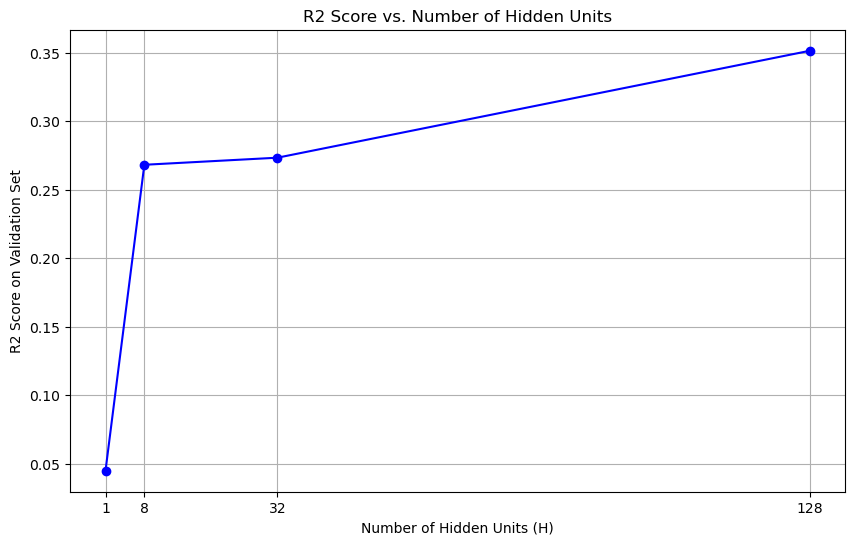

In [51]:
if running_index == 8:
    plt.figure(figsize=(10, 6))
    plt.plot(hidden_units, mean_r2_all, marker='o', linestyle='-', color='b')
    plt.title('R2 Score vs. Number of Hidden Units')
    plt.xlabel('Number of Hidden Units (H)')
    plt.ylabel('R2 Score on Validation Set')
    plt.grid(True)
    plt.xticks(hidden_units)
    plt.savefig('./pic/R2_Score_vs_Hidden_Units.png')
    plt.show()

    running_index = running_index + 1

else:
    image_path = './pic/R2_Score_vs_Hidden_Units.png' 
    display(Image(filename=image_path))




## Part 4: Classification

In [52]:
np.random.seed(random_seed)
random.seed(random_seed)
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(train_fe, train_labels['classification target'], test_size=0.2, random_state=random_seed)

### Logistic Regression:

#### Training Function for All Logistic Regression Model:

In [53]:
def train_model_classification(X_train, y_train, X_test, y_test, n, lr_para = lr_para, trail = "", random_seed = random_seed):
    x = X_train
    y = y_train.values 

    regressor_c = SGDClassifier(**lr_para, random_state=random_seed)

    
    start_time = time.time()

    lrm = regressor_c.fit(x, y)

    training_time = time.time() - start_time

#    print("Training time:", training_time)

#    for name in lr_para:
#        print(name + ':', lr_para[name])

    training_accuracy = lrm.score(x, y)
#    print("Training accuracy:", lrm.score(x, y))

    y_pred = lrm.predict(X_test)
    y_v = y_test.values

    test_accuracy = np.mean(y_pred == y_v)
#    print("Testing accuracy:", np.mean(y_pred == y_v))

    f1 = f1_score(y_v, y_pred, average='weighted')
#    print("F1 score:", f1)

    if not os.path.exists('./result/classification'):
        os.makedirs('./result/classification')

#    with open(f'./result/classification/model{n+1}{trail}.txt', 'w') as f:
#        f.write("Training time: " + str(training_time) + '\n')
#        f.write("Learning rate: " + str(lr_para['learning_rate']) + '\n')
#        f.write("Eta0: " + str(lr_para['eta0']) + '\n')
#        f.write("Max iter: " + str(lr_para['max_iter']) + '\n')
#        f.write("Tol: " + str(lr_para['tol']) + '\n')
#        f.write("Training accuracy: " + str(lrm.score(x, y)) + '\n')
#        f.write("Testing accuracy: " + str(np.mean(y_pred == y_v)) + '\n')
#        f.write("F1 score: " + str(f1) + '\n')
    
    return lrm, training_time, f1, test_accuracy, training_accuracy

#### Non-repeat and Reported Model:

learning_rate: constant
eta0: 0.02
max_iter: 1000
tol: 0.001
Average Training Time: 0.0023664633433024087 (±0.00028502116531962273)
Average F1 Score: 0.822635474587186 (±0.009804266536937478)
Average Testing Accuracy: 0.8258003766478343 (±0.011319035103739447)
Average Training Accuracy: 0.7919463087248322 (±0.013792645796641339)



learning_rate: constant
eta0: 0.01
max_iter: 1000
tol: 0.001
Average Training Time: 0.002276261647542318 (±0.000272568598826622)
Average F1 Score: 0.8498166482196053 (±0.0014496011152904385)
Average Testing Accuracy: 0.8549905838041432 (±0.0013316511886752446)
Average Training Accuracy: 0.82114682679854 (±0.0024015163139492765)

learning_rate: constant
eta0: 0.02
max_iter: 1000
tol: 0.01
Average Training Time: 0.0018715063730875652 (±6.933960326947578e-05)
Average F1 Score: 0.7987004645359935 (±0.026712507614609846)
Average Testing Accuracy: 0.8022598870056498 (±0.027988444345954523)
Average Training Accuracy: 0.7620393265041798 (±0.036076200362029825)

learning_rate: constant
eta0: 0.01
max_iter: 1000
tol: 0.01
Average Training Time: 0.0018242994944254558 (±2.4384314490157595e-05)
Average F1 Score: 0.8228004364767753 (±0.006146004397053691)
Average Testing Accuracy: 0.8262711864406779 (±0.006102392371382144)
Average Training Accuracy: 0.7866478276227481 (±0.018519155080417148)

learni

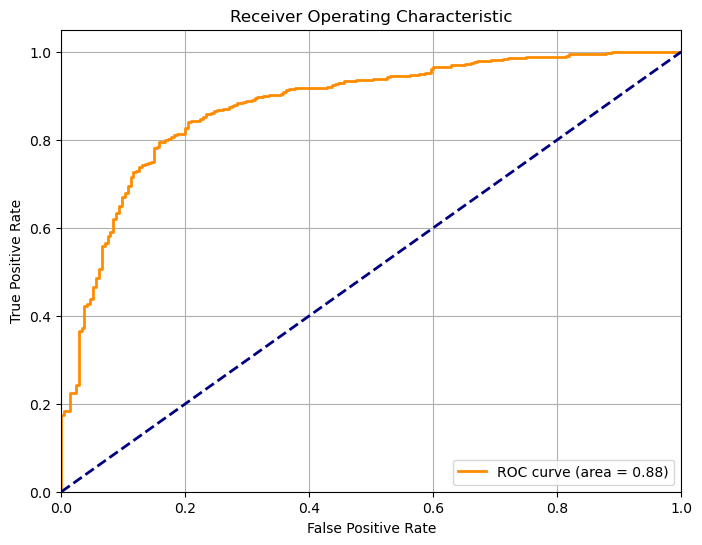

In [54]:
eta0_list = [0.02, 0.01]
tol_list = [1e-3, 1e-2]
learning_rate_list = ['constant', 'optimal']

# Plot the ROC curve calculated on the validation set with the last model
if running_index == 9:

    for n in range(len(learning_rate_list)):
        for k in range(len(tol_list)):
            for j in range(len(eta0_list)):
                
                lr_para_test = {
                    'learning_rate':learning_rate_list[n], 
                    'eta0':eta0_list[j], 
                    'max_iter':1000, 
                    'tol':tol_list[k]
                    }

                training_times = []
                f1_scores = []
                test_accuracies = []
                training_accuracies = []

                for i in range(3):
                    model, training_time, f1, test_accuracy, training_accuracy = train_model_classification(
                        X_train_LR, y_train_LR, X_test_LR, y_test_LR, running_index, lr_para_test, f"_set{j}_trial_{i+1}", i+random_seed)

                    training_times.append(training_time)
                    f1_scores.append(f1)
                    test_accuracies.append(test_accuracy)
                    training_accuracies.append(training_accuracy)

                for name in lr_para_test:
                    print(name + ':', lr_para_test[name])

                avg_training_time = np.mean(training_times)
                std_training_time = np.std(training_times)

                avg_f1_score = np.mean(f1_scores)
                std_f1_score = np.std(f1_scores)

                avg_test_accuracy = np.mean(test_accuracies)
                std_test_accuracy = np.std(test_accuracies)

                avg_training_accuracy = np.mean(training_accuracies)
                std_training_accuracy = np.std(training_accuracies)

                print(f"Average Training Time: {avg_training_time} (±{std_training_time})")
                print(f"Average F1 Score: {avg_f1_score} (±{std_f1_score})")
                print(f"Average Testing Accuracy: {avg_test_accuracy} (±{std_test_accuracy})")
                print(f"Average Training Accuracy: {avg_training_accuracy} (±{std_training_accuracy})")
                print()

                if j == len(eta0_list) - 1 and k == len(tol_list) - 1 and n == len(learning_rate_list) - 1:
                    y_score = model.decision_function(X_test_LR)

                    fpr, tpr, _ = roc_curve(y_test_LR, y_score, pos_label='success')
                    roc_auc = auc(fpr, tpr)

                    plt.figure(figsize=(8, 6))
                    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('Receiver Operating Characteristic')
                    plt.legend(loc="lower right")
                    plt.grid(True)
                    plt.savefig(f'./pic/ROC_curve_set{4*n + 2*k +j}.png')
                    plt.show()     

                if not os.path.exists('./result/classification'):
                    os.makedirs('./result/classification')

                with open(f'./result/classification/model10_set{4*n+2*k+j}.txt', 'w') as f:
                    f.write(f"Learning Rate" + str(lr_para_test['learning_rate']) + '\n')
                    f.write(f"Eta0: {lr_para_test['eta0']}\n")
                    f.write(f"Max Iter: {lr_para_test['max_iter']}\n")
                    f.write(f"Tol: {lr_para_test['tol']}\n")
                    f.write(f"Average Training Time: {avg_training_time} (±{std_training_time})\n")
                    f.write(f"Average F1 Score: {avg_f1_score} (±{std_f1_score})\n")
                    f.write(f"Average Testing Accuracy: {avg_test_accuracy} (±{std_test_accuracy})\n")
                    f.write(f"Average Training Accuracy: {avg_training_accuracy} (±{std_training_accuracy})\n")
            
    running_index = running_index + 1
    
else:
    for n in range(8):
        with open(f'./result/classification/model10_set{n}.txt', 'r') as f:
            print(f.read())

    image_path = './pic/ROC_curve_set0.png'

    display(Image(filename=image_path))

#### Different Learning Rate

In [55]:
eta0_list = [0.05, 0.04, 0.03, 0.02, 0.01]
# Plot the ROC curve calculated on the validation set with the last model
if running_index == 10:

    for j in range(len(eta0_list)):

        eta0 = eta0_list[j]
        lr_para_test = {
            'learning_rate':'constant', 
            'eta0':eta0, 
            'max_iter':1000, 
            'tol':1e-3
            }

        model, training_time, f1, test_accuracy, training_accuracy = train_model_classification(
                X_train_LR, y_train_LR, X_test_LR, y_test_LR, running_index, lr_para_test, f"_set{j}_trial_{i+1}", random_seed)

        print(f"Learning Rate: {lr_para_test['learning_rate']}")
        print(f"Training Time: {training_time}")
        print(f"F1 Score: {f1}")
        print(f"Testing Accuracy: {test_accuracy}")
        print(f"Training Accuracy: {training_accuracy}")
        print()

        if not os.path.exists('./result/classification'):
            os.makedirs('./result/classification')

        with open(f'./result/classification/model{running_index+1}_lr{eta0}.txt', 'w') as f:
            f.write(f"Learning Rate" + str(lr_para_test['learning_rate']) + '\n')
            f.write(f"Eta0: {lr_para_test['eta0']}\n")
            f.write(f"Max Iter: {lr_para_test['max_iter']}\n")
            f.write(f"Tol: {lr_para_test['tol']}\n")
            f.write(f"Training Time: {training_time}\n")
            f.write(f"F1 Score: {f1}\n")
            f.write(f"Testing Accuracy: {test_accuracy}\n")
            f.write(f"Training Accuracy: {training_accuracy}\n")

else:
    for j in range(len(eta0_list)):
        with open(f'./result/classification/model{running_index+1}_lr{eta0_list[j]}.txt', 'r') as f:
            print(f.read())

Learning Rate: constant
Training Time: 0.0031023025512695312
F1 Score: 0.7659580575475979
Testing Accuracy: 0.7740112994350282
Training Accuracy: 0.7237725185446838

Learning Rate: constant
Training Time: 0.001783132553100586
F1 Score: 0.7997900801428992
Testing Accuracy: 0.806497175141243
Training Accuracy: 0.7594489579653833

Learning Rate: constant
Training Time: 0.0018153190612792969
F1 Score: 0.7821879756936488
Testing Accuracy: 0.788135593220339
Training Accuracy: 0.7545037089367714

Learning Rate: constant
Training Time: 0.002329587936401367
F1 Score: 0.8164100529410732
Testing Accuracy: 0.8177966101694916
Training Accuracy: 0.7788767220063582

Learning Rate: constant
Training Time: 0.002576112747192383
F1 Score: 0.8478727374059388
Testing Accuracy: 0.8531073446327684
Training Accuracy: 0.8202048746026139

